# Example of readin in different synchrotron emision templates
In this notebook, we will generate a log-normal field, transform to redshift-space, add synchrotron emission made using different resolution spectral inde maps, then test how PCA removes these differing foregournds

In [1]:
import numpy as np
import numpy.fft as fft
import pylab as plt
import pyccl as ccl
plt.rcParams["figure.figsize"] = (14,7)

In [2]:
import fastbox
from fastbox.box import CosmoBox, default_cosmo
from fastbox.foregrounds import PlanckSkyModel, HighResSyncModel

## Generate simulation box
Generate a Gaussian random realisation with a non-linear power spectrum on a (2 Gpc)^3 grid with 128^3 cells at redshift z=0.8. Then, paint biased HI onto the density field, apply a log-normal transformation, add linear and non-linear velocities to transform to redshift space, and finally rescale by the brightness temperature.

In [3]:
# (1a) Generate Gaussian box (2 Gpc on each side, 128^3 grid, z=0.8)
box = CosmoBox(cosmo=default_cosmo, box_scale=(1e3,1e3,1e3), nsamp=64, 
               redshift=0.3, realise_now=False)
box.realise_density()

# (1b) Rescale tracer by bias [FIXME: Check this is being done in the right order]
tracer = fastbox.tracers.HITracer(box)
delta_hi = box.delta_x * tracer.bias_HI()

# (1c) Transform to a log-normal field
delta_ln = box.lognormal(delta_hi)

# (1d) Calculate radial velocity field (uses Gaussian density field; FIXME)
vel_k = box.realise_velocity(delta_x=box.delta_x, inplace=True)
vel_z = fft.ifftn(vel_k[2]).real # inverse FFT to get real-space radial velocity

# (1e) Transform to redshift space (also add non-linear velocity, sigma_nl=120 km/s)
delta_s = box.redshift_space_density(delta_x=delta_ln.real, velocity_z=vel_z, 
                                     sigma_nl=120., method='linear')

# (1f) Scale by mean brightness temperature (in mK), and include mean
signal_cube = tracer.signal_amplitude() * (1. + delta_s)

/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/pyccl/pk2d.py:198: RuntimeWarning: divide by zero encountered in log
  f, status = lib.pk2d_eval_multi(self.psp, np.log(k_use),
/Users/mirfan/Documents/FastBox/FastBox/fastbox/box.py:254: RuntimeWarning: invalid value encountered in true_divide
  Ax = 1.j * delta_k * self.Kx * (2.*np.pi/self.Lx) / k2
/Users/mirfan/Documents/FastBox/FastBox/fastbox/box.py:255: RuntimeWarning: invalid value encountered in true_divide
  Ay = 1.j * delta_k * self.Ky * (2.*np.pi/self.Ly) / k2
/Users/mirfan/Documents/FastBox/FastBox/fastbox/box.py:256: RuntimeWarning: invalid value encountered in true_divide
  Az = 1.j * delta_k * self.Kz * (2.*np.pi/self.Lz) / k2


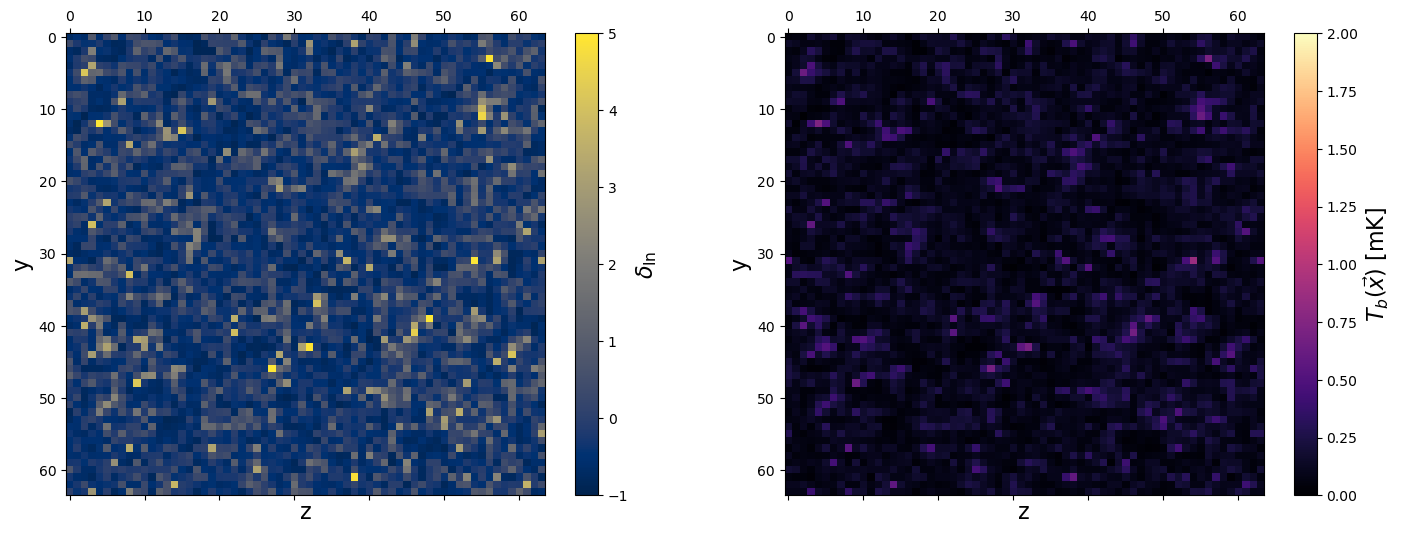

In [4]:
plt.subplot(121)
plt.matshow(delta_ln[10,:,:], vmin=-1., vmax=5., cmap='cividis', aspect='auto', fignum=False)
plt.xlabel("z", fontsize=16)
plt.ylabel("y", fontsize=16)
cbar = plt.colorbar()
cbar.set_label(label=r"$\delta_{\rm ln}$", fontsize=16)

plt.subplot(122)
plt.matshow(signal_cube[10,:,:], vmin=0., vmax=2., cmap='magma', aspect='auto', fignum=False)
plt.xlabel("z", fontsize=16)
plt.ylabel("y", fontsize=16)
cbar = plt.colorbar()
cbar.set_label(label=r"$T_b(\vec{x})$ [mK]", fontsize=16.)
plt.gcf().set_size_inches((17., 6.))

## Add synchrotron emission  - two different models 
Synchroton emission model 1): amplitude at 408 MHz given by Haslam data, spectral index map from Planck Sky Model at 5 degree resolution with higher resolution up to 56 arcmin provided using CNNs.

Synchrotron emission model 2): amplitude at 408 MHz given by Haslam data, spectral index map from Planck Sky Model at 5 degree resolution with higher resolution up to 56 arcmin provided using a Gaussian realisation. 

In [5]:
# Output frequency range
freqs = box.freq_array()
n_ch = len(freqs)
print("Frequency range: %3.1f -- %3.1f MHz\n" % (freqs[-1], freqs[0]))

# Angular pixels
ang_x, ang_y = box.pixel_array(redshift=box.redshift)
xside = len(ang_x)
yside = len(ang_y)

#Model 1
fg_psm = PlanckSkyModel(box)
syncamp, _, syncind = fg_psm.synch_freefree_maps(rotation=(0., -62., 0.), ref_freq=1000.)

syncmap = np.zeros((xside,yside,n_ch))
for i in range(n_ch):
    syncmap[:,:,i] = syncamp * (freqs[i]/freqs[0])**(syncind)

fg_cube1 = syncmap

#Model 2
fg_hires = HighResSyncModel(box)
fg_cube2 = fg_hires.construct_cube(lat0=-62., lon0=0., redshift=None, loop=True, verbose=True)


Frequency range: 980.0 -- 1205.2 MHz

    Channel 0 / 64
    Channel 10 / 64
    Channel 20 / 64
    Channel 30 / 64
    Channel 40 / 64
    Channel 50 / 64
    Channel 60 / 64


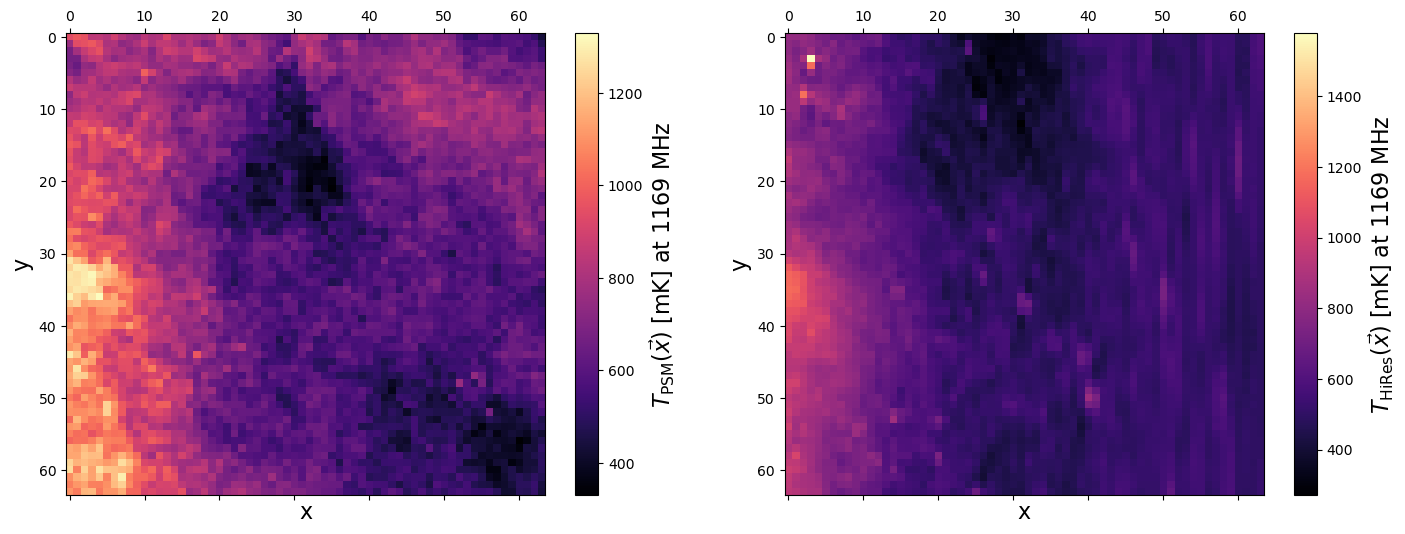

In [6]:
plt.subplot(121)
plt.matshow(fg_cube1[:,:,10].T, cmap='magma', aspect='auto', fignum=False)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
cbar = plt.colorbar()
cbar.set_label(label=r"$T_{\rm PSM}(\vec{x})$ [mK] at %d MHz" % (box.freq_array()[10]), fontsize=16.)
plt.gcf().set_size_inches((17., 6.))

plt.subplot(122)
plt.matshow(fg_cube2[:,:,10].T, cmap='magma', aspect='auto', fignum=False)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
cbar = plt.colorbar()
cbar.set_label(label=r"$T_{\rm HiRes}(\vec{x})$ [mK] at %d MHz" % (box.freq_array()[10]), fontsize=16.)
plt.gcf().set_size_inches((17., 6.))

#the PSM is at an Nside of 2048, while the high res is at Nside 512 before they both get smoothed by the instrument beam

## Add radiometer noise
### Adds a simple homogeneous white noise field for a MeerKAT-like multi-dish deep integration (64 dishes, 2 hours per pointing, assumed 1 degree FOV per pointing).

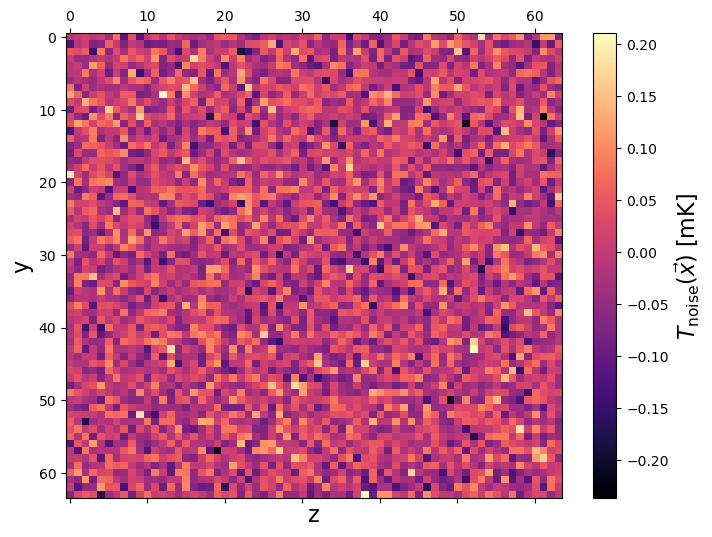

In [7]:
# Generate homogeneous radiometer noise
noise_model = fastbox.noise.NoiseModel(box)
noise_cube = noise_model.realise_radiometer_noise(Tinst=18., tp=0.25, fov=1., Ndish=64)

plt.matshow(noise_cube[10,:,:], cmap='magma', aspect='auto')
plt.xlabel("z", fontsize=16)
plt.ylabel("y", fontsize=16)
cbar = plt.colorbar()
cbar.set_label(label=r"$T_{\rm noise}(\vec{x})$ [mK]", fontsize=16.)
plt.gcf().set_size_inches((8., 6.))

## Construct final data cube (convolve with beam and add noise)

In [8]:
# Construct MeerKAT L-band beam
mkbeam = fastbox.beams.KatBeamModel(box, model='L')

In [9]:
# Convolve with beam
obs_cube1 = mkbeam.convolve_real(signal_cube + fg_cube1, pol='I')
obs_cube2 = mkbeam.convolve_real(signal_cube + fg_cube2, pol='I')

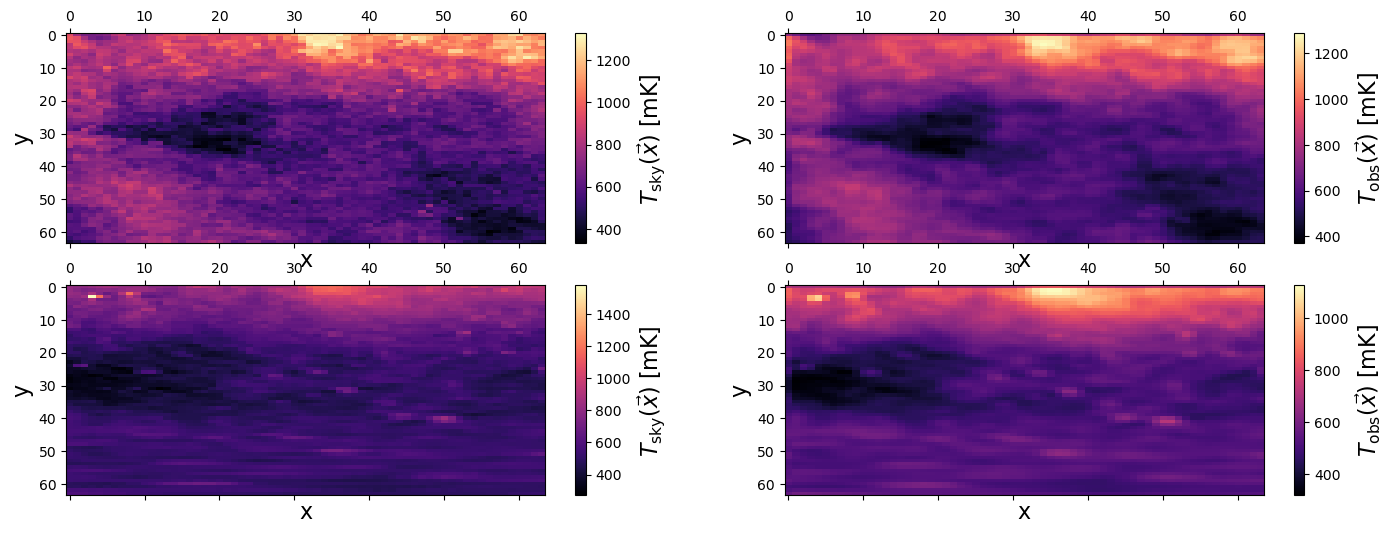

In [10]:
# Plot before and after beam convolution
plt.subplot(221)
plt.matshow((signal_cube + fg_cube1)[:,:,10], cmap='magma', aspect='auto', fignum=False)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
cbar = plt.colorbar()
cbar.set_label(label=r"$T_{\rm sky}(\vec{x})$ [mK]", fontsize=16.)

plt.subplot(222)
plt.matshow(obs_cube1[:,:,10], cmap='magma', aspect='auto', fignum=False)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
cbar = plt.colorbar()
cbar.set_label(label=r"$T_{\rm obs}(\vec{x})$ [mK]" % (box.freq_array()[10]), fontsize=16.)
plt.gcf().set_size_inches((17., 6.))

plt.subplot(223)
plt.matshow((signal_cube + fg_cube2)[:,:,10], cmap='magma', aspect='auto', fignum=False)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
cbar = plt.colorbar()
cbar.set_label(label=r"$T_{\rm sky}(\vec{x})$ [mK]", fontsize=16.)

plt.subplot(224)
plt.matshow(obs_cube2[:,:,10], cmap='magma', aspect='auto', fignum=False)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
cbar = plt.colorbar()
cbar.set_label(label=r"$T_{\rm obs}(\vec{x})$ [mK]" % (box.freq_array()[10]), fontsize=16.)
plt.gcf().set_size_inches((17., 6.))

In [11]:
# Combine beam-convolve observation and noise
data_cube1 = obs_cube1 + noise_cube
data_cube2 = obs_cube2 + noise_cube

## Try FG cleaning method using PCA

In [12]:
cleaned_cube1, U_fg1, amp_fg1 = fastbox.filters.pca_filter(data_cube1, 
                                                         nmodes=3, 
                                                         return_filter=True)
cleaned_cube2, U_fg2, amp_fg2 = fastbox.filters.pca_filter(data_cube2, 
                                                         nmodes=3, 
                                                         return_filter=True)

In [13]:
#plot power spectra
proc_k1, proc_pk1, proc_stddev1 = box.binned_power_spectrum(delta_x=cleaned_cube1, nbins=50)
proc_k2, proc_pk2, proc_stddev2 = box.binned_power_spectrum(delta_x=cleaned_cube2, nbins=50)
sig_k, sig_pk, sig_stddev = box.binned_power_spectrum(delta_x=signal_cube, nbins=50)

/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Amplitude factor for theoretical spectrum


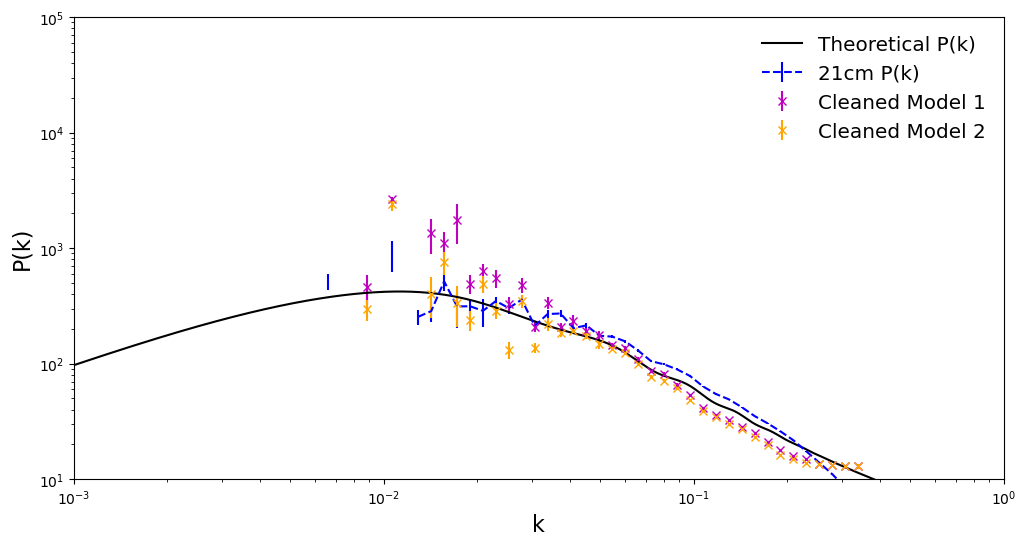

In [14]:
print("Amplitude factor for theoretical spectrum")
th_k, th_pk = box.theoretical_power_spectrum()
amp_fac = (tracer.signal_amplitude() * tracer.bias_HI())**2. # FIXME: No RSD contrib.

# Plot power spectra
plt.subplot(111)
plt.plot(th_k, th_pk * amp_fac, 'k-', label="Theoretical P(k)")
plt.errorbar(sig_k, sig_pk, yerr=sig_stddev, color='b', ls='dashed', label="21cm P(k)")

plt.errorbar(proc_k1, proc_pk1, yerr=proc_stddev1, color='m', marker='x', ls='none',label="Cleaned Model 1")
plt.errorbar(proc_k2, proc_pk2, yerr=proc_stddev2, color='orange', marker='x', ls='none',label="Cleaned Model 2")

plt.legend(loc='upper right', frameon=False, prop={'size':'x-large'})
plt.xlim((1e-3, 1e0))
plt.ylim((1e1, 1e5))
plt.xscale('log')
plt.yscale('log')
plt.xlabel("k", size=16)
plt.ylabel("P(k)", size=16)

plt.gcf().set_size_inches((12., 6.))
plt.show()